## **Merging DTM Raster Tiles**

- The dataset consists of **multiple raster tiles** for King County.
- We use **GDAL's `gdal_merge.py` tool** to **merge** them into a single DTM file.

### **Steps**
1. Load all **TIFF files** (DTM tiles).
2. Merge them into **one raster** with **LZW compression**.
3. Enable **BIGTIFF support** for large files.

In [14]:
!ls -lh ../data/raw/proj_raster_data/

total 3.1G
-rw-r--r-- 1 jovyan users 701M Feb 27 23:44 king_county_2016_dtm_52.tif
-rw-r--r-- 1 jovyan users 696M Feb 27 23:45 king_county_2016_dtm_53.tif
-rw-r--r-- 1 jovyan users 173M Feb 27 23:45 king_county_2016_dtm_54.tif
-rw-r--r-- 1 jovyan users 650M Feb 27 23:41 king_county_2016_dtm_65.tif
-rw-r--r-- 1 jovyan users 721M Feb 27 23:42 king_county_2016_dtm_66.tif
-rw-r--r-- 1 jovyan users 191M Feb 27 23:41 king_county_2016_dtm_67.tif


In [15]:
import glob
import subprocess

# Get the list of all TIFF files
tif_files = sorted(glob.glob("../data/raw/proj_raster_data/*.tif"))

# Check if files are found
if not tif_files:
    print("❌ No TIFF files found! Check the directory path.")
else:
    print(f"✅ Found {len(tif_files)} files, merging...")

    # Merge using GDAL with BigTIFF support
    cmd = [
        "gdal_merge.py",
        "-o", "../data/raw/king_county_2016_merged.tif",
        "-n", "0", "-a_nodata", "0",
        "-co", "COMPRESS=LZW",
        "-co", "BIGTIFF=YES"
    ] + tif_files  # Append the file list instead of using wildcard

    # Run the command
    subprocess.run(cmd, check=True)

✅ Found 6 files, merging...
0...10...20...30...40...50...60...70...80...90...100 - done.


## **Checking the Coordinate Reference System (CRS)**

- **Seattle boundary data** and the **DTM raster** must have the **same CRS** for proper spatial alignment.
- The **Seattle dataset CRS is EPSG:4326**, but **DTM uses EPSG:2927**.

In [1]:
import geopandas as gpd

# Load Seattle geometry
seattle_gdf = gpd.read_file('https://raw.githubusercontent.com/seattleflu/seattle-geojson/master/seattle_geojsons/2016_seattle_city.geojson')

In [2]:
seattle_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [3]:
import rasterio

# Use the correct file path
dtm_path = "/home/jovyan/seattle-micromobility/data/raw/king_county_2016_merged.tif"

# Open the raster and check CRS
with rasterio.open(dtm_path) as src:
    print("DTM CRS:", src.crs)

DTM CRS: PROJCS["NAD83(HARN) / Washington South (ftUS)",GEOGCS["NAD83(HARN)",DATUM["NAD83_High_Accuracy_Reference_Network",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6152"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",45.3333333333333],PARAMETER["central_meridian",-120.5],PARAMETER["standard_parallel_1",45.8333333333333],PARAMETER["standard_parallel_2",47.3333333333333],PARAMETER["false_easting",1640416.66666667],PARAMETER["false_northing",0],UNIT["US survey foot",0.304800609601219,AUTHORITY["EPSG","9003"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


## **Reprojecting Seattle Boundary to Match DTM CRS**

- Since **Seattle's CRS (EPSG:4326)** is different from the **DTM CRS (EPSG:2927)**, we **convert it**.
- This ensures **correct spatial overlay** when clipping the raster.

In [4]:
# Ensure Seattle boundary CRS matches the raster CRS
with rasterio.open(dtm_path) as src:
    dtm_crs = src.crs  # Get CRS of DTM raster

seattle_gdf = seattle_gdf.to_crs(dtm_crs)  # Convert boundary CRS to match raster

## **Clipping the DTM to Seattle Boundary**

- The **original DTM covers a larger area**, but we **only need Seattle**.
- We use **raster masking** to extract **only the Seattle area**.

In [5]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd

# File paths

clipped_dtm_path = "/home/jovyan/seattle-micromobility/data/processed/seattle_dtm_clipped.tif"

# Open the raster and clip using the Seattle boundary
with rasterio.open(dtm_path) as src:
    out_image, out_transform = mask(src, seattle_gdf.geometry, crop=True)
    out_meta = src.meta.copy()
    out_meta.update({
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

# Save the clipped raster
with rasterio.open(clipped_dtm_path, "w", **out_meta) as dest:
    dest.write(out_image)

print(f"✅ Clipping complete! Clipped DTM saved as: '{clipped_dtm_path}'")

✅ Clipping complete! Clipped DTM saved as: '/home/jovyan/seattle-micromobility/data/processed/seattle_dtm_clipped.tif'


## **Converting Elevation to Meters**

- The original DTM uses **feet**, but slope calculations require **meters**.
- We **convert elevation from feet to meters**.

In [7]:
!gdalwarp -t_srs EPSG:2285 \
          -tr 3 3 \
          -r bilinear \
          -co COMPRESS=LZW \
          -of GTiff \
          "/home/jovyan/seattle-micromobility/data/processed/seattle_dtm_clipped.tif" \
          "/tmp/seattle_dtm_meter.tif"

Creating output file that is 17537P x 29009L.
Using internal nodata values (e.g. 0) for image /home/jovyan/seattle-micromobility/data/processed/seattle_dtm_clipped.tif.
Copying nodata values from source /home/jovyan/seattle-micromobility/data/processed/seattle_dtm_clipped.tif to destination /tmp/seattle_dtm_meter.tif.
...10...20...30...40...50...60...70...80...90...100 - done.d/seattle_dtm_clipped.tif [1/1] : 0


## **Downsampling the Raster to Reduce File Size**

- **Processing high-resolution DTM can be slow**.
- We **downsample it to 5m resolution** for faster analysis.

In [8]:
!gdalwarp -tr 5 5 -r bilinear \
    "/tmp/seattle_dtm_meter.tif" \
    "/home/jovyan/seattle-micromobility/data/processed/seattle_dtm_lowres.tif"

Creating output file that is 10522P x 17405L.
Using internal nodata values (e.g. 0) for image /tmp/seattle_dtm_meter.tif.
Copying nodata values from source /tmp/seattle_dtm_meter.tif to destination /home/jovyan/seattle-micromobility/data/processed/seattle_dtm_lowres.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


## **Computing the Slope Raster**

1. **Load the elevation raster**.
2. **Compute gradients** in **X and Y directions**.
3. **Convert rise-over-run to degrees**.
4. **Save the slope raster**.

In [1]:
import rasterio
import numpy as np

# File paths
dtm_path = "/home/jovyan/seattle-micromobility/data/processed/seattle_dtm_lowres.tif"  # Input DTM in meters
slope_path = "/home/jovyan/seattle-micromobility/data/processed/seattle_slope.tif"  # Output slope raster

# Open the DTM raster
with rasterio.open(dtm_path) as src:
    elevation = src.read(1).astype(float)  # Read elevation as float
    profile = src.profile  # Get metadata
    x_res, y_res = src.res  # Get resolution in X and Y (meters)

# Compute slope
dz_dx = np.gradient(elevation, axis=1) / x_res  # Gradient in X direction
dz_dy = np.gradient(elevation, axis=0) / y_res  # Gradient in Y direction
slope = np.arctan(np.sqrt(dz_dx**2 + dz_dy**2)) * (180 / np.pi)  # Convert to degrees

# Convert to float32 to reduce file size
slope = slope.astype(np.float32)

# Update metadata for output raster
profile.update(dtype=rasterio.float32, nodata=0, compress='lzw')

# Save the optimized slope raster
with rasterio.open(slope_path, "w", **profile) as dst:
    dst.write(slope, 1)

print(f"✅ Optimized Slope Raster Saved: {slope_path}")

✅ Optimized Slope Raster Saved: /home/jovyan/seattle-micromobility/data/processed/seattle_slope.tif


In [2]:
!gdalwarp -tr 10 10 -r bilinear \
    "/home/jovyan/seattle-micromobility/data/processed/seattle_slope.tif" \
    "/home/jovyan/seattle-micromobility/data/processed/seattle_slope_lowres.tif"

Creating output file that is 5261P x 8703L.
Using internal nodata values (e.g. 0) for image /home/jovyan/seattle-micromobility/data/processed/seattle_slope.tif.
Copying nodata values from source /home/jovyan/seattle-micromobility/data/processed/seattle_slope.tif to destination /home/jovyan/seattle-micromobility/data/processed/seattle_slope_lowres.tif.
...10...20...30...40...50...60...70...80...90...100 - done.d/seattle_slope.tif [1/1] : 0


## **Visualizing the Slope Raster**

- Helps verify that **slope is correctly calculated**.
- Shows **steep vs. flat areas** in Seattle.

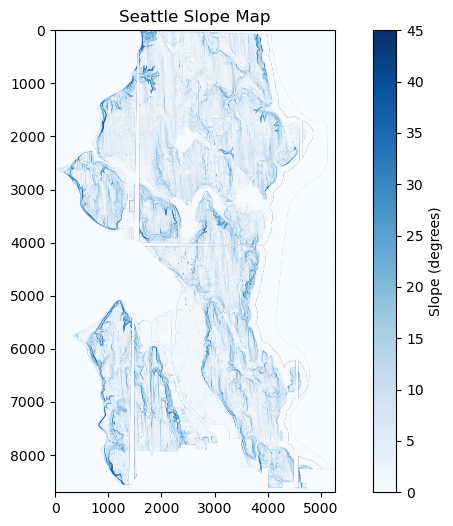

In [1]:
import rasterio
import matplotlib.pyplot as plt

# Path to the saved slope raster
slope_path = "/home/jovyan/seattle-micromobility/data/processed/seattle_slope_lowres.tif"

# Open the slope raster
with rasterio.open(slope_path) as src:
    slope_data = src.read(1)

# Plot slope raster
plt.figure(figsize=(10, 6))
plt.imshow(slope_data, cmap="Blues", vmin=0, vmax=45)
plt.colorbar(label="Slope (degrees)")
plt.title("Seattle Slope Map")
plt.show()

In [3]:
import numpy as np

# Remove no-data values (assuming 0 represents no-data)
valid_slope_values = slope_data[slope_data > 0]

# Compute statistics
mean_slope = np.mean(valid_slope_values)
median_slope = np.median(valid_slope_values)
std_slope = np.std(valid_slope_values)
max_slope = np.max(valid_slope_values)

print(f"Slope Statistics:")
print(f"   - Mean Slope: {mean_slope:.2f}°")
print(f"   - Median Slope: {median_slope:.2f}°")
print(f"   - Standard Deviation: {std_slope:.2f}°")
print(f"   - Max Slope: {max_slope:.2f}°")

Slope Statistics:
   - Mean Slope: 6.38°
   - Median Slope: 3.41°
   - Standard Deviation: 8.58°
   - Max Slope: 90.00°


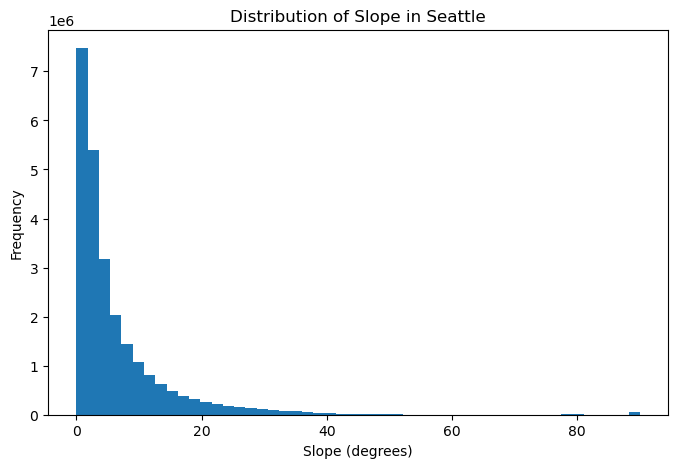

In [9]:
plt.figure(figsize=(8,5))
plt.hist(valid_slope_values, bins=50)
plt.xlabel("Slope (degrees)")
plt.ylabel("Frequency")
plt.title("Distribution of Slope in Seattle")
plt.show()

In [ ]:
import geopandas as gpd
import rasterio
import numpy as np

# Load Seattle Neighborhood Boundaries
seattle_neighborhoods = gpd.read_file("https://opendata.arcgis.com/datasets/a49e4d4a338c4b5dbece4dc968cd534f_2.geojson")  
seattle_neighborhoods = seattle_neighborhoods.to_crs(epsg=2285)  # Match raster CRS

# Load the slope raster
slope_path = "/home/jovyan/seattle-micromobility/data/processed/seattle_slope_lowres.tif"
with rasterio.open(slope_path) as src:
    slope_array = src.read(1)  # Read full raster
    slope_transform = src.transform  # Get spatial transform

# Compute mean slope per neighborhood
seattle_neighborhoods["avg_slope"] = seattle_neighborhoods.geometry.apply(
    lambda geom: np.nanmean([slope_array[row, col] 
                             for row, col in 
                             [src.index(x, y) for x, y in zip(*geom.exterior.xy)] 
                             if 0 <= row < slope_array.shape[0] and 0 <= col < slope_array.shape[1]])
)

print("✅ Average slope computed per neighborhood.")